In [1]:
import pandas as pd
import jieba
import re
import matplotlib
import matplotlib.pyplot as plt
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import pyLDAvis.gensim_models
import numpy as np

from pymongo import MongoClient
import pymongo

In [2]:
# 使用GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
! nvidia-smi

Sun Jun 26 01:19:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 45%   56C    P2    67W / 260W |   7437MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 27%   

# LDA

## 2015 brief paragraph

In [3]:
file_de = open("../LDA/segment/data/de_file_brief_paragraph_2015.txt", "r")
de_lines = file_de.readlines()

In [4]:
de_desc = [i.replace(" \n","").split(" ") for i in de_lines]

In [5]:
id2word = corpora.Dictionary(de_desc)
print('資料集字典：')
print(id2word)

資料集字典：
Dictionary(903 unique tokens: ['al', 'amin', 'ammonium', 'anion', 'anionen']...)


In [6]:
corpus = [id2word.doc2bow(text) for text in de_desc]
print('第一篇文章 corpus :')
print(corpus[0][:10])

第一篇文章 corpus :
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]


+ corpus = 文檔語料庫
+ id2word = 詞彙字典
+ num_topics = 生成幾個主題數
+ random_state = 固定亂數值，每次的模型結果會一樣
+ iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
+ passes(epoch) = 整個 corpus 訓練模型的次數
+ alpha = 文章主題分佈
+ eta = 主題字分佈

In [7]:
topic_num_list = np.arange(2, 26, 1)
result = []
for topic_num in topic_num_list:
    # perplexity
    tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=id2word,
        random_state = 1500,
        passes=5,
        iterations=2000
        )
    tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)
    temp_skleran = np.exp(-1. * tmp_perplexity)
    
    result.append({"topic_num": topic_num, "gensim_perplexity": tmp_perplexity, "perplexity":temp_skleran})
    print(topic_num)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


,topic_num,gensim_perplexity,perplexity
0,2,-6.613147,744.823607
1,3,-6.631446,758.578418
2,4,-6.627349,755.476458
3,5,-6.567161,711.347367
4,6,-6.571880,714.712493
5,7,-6.568953,712.622988
6,8,-6.545466,696.080882
7,9,-6.521283,679.449397
8,10,-6.526551,683.038481
9,11,-6.471918,646.723103


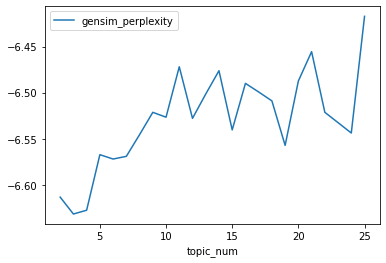

In [8]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='gensim_perplexity', label='gensim_perplexity')
result

,topic_num,gensim_perplexity,perplexity
0,2,-6.613147,744.823607
1,3,-6.631446,758.578418
2,4,-6.627349,755.476458
3,5,-6.567161,711.347367
4,6,-6.571880,714.712493
5,7,-6.568953,712.622988
6,8,-6.545466,696.080882
7,9,-6.521283,679.449397
8,10,-6.526551,683.038481
9,11,-6.471918,646.723103


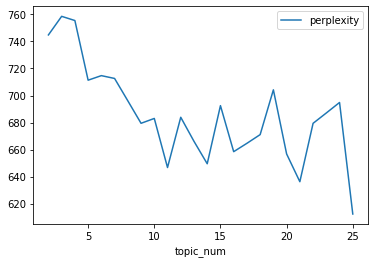

In [9]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='perplexity', label='perplexity')
result

In [10]:
# 儲存LDA_result
result.to_csv("./result/LDA_de_brief_paragraph_2015.csv", index=False)

## priority description sentence

In [11]:
# file_us = open("../MUSE-main/data/us_file_desc_p_s_2500.txt", "r")
# us_lines = file_us.readlines()

# file_us = open("../MUSE-main/data/us_file_desc_p_s_2500.txt", "r")
# us_lines = file_us.readlines()

In [12]:
# us_desc = [i.replace(" \n","").split(" ") for i in us_lines]
# us_desc = [i.replace(" \n","").split(" ") for i in us_lines]

In [13]:
# id2word = corpora.Dictionary(us_desc)
# print('資料集字典：')
# print(id2word)

In [14]:
# corpus = [id2word.doc2bow(text) for text in us_desc]
# print('第一篇文章 corpus :')
# print(corpus[0][:10])

+ corpus = 文檔語料庫
+ id2word = 詞彙字典
+ num_topics = 生成幾個主題數
+ random_state = 固定亂數值，每次的模型結果會一樣
+ iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
+ passes(epoch) = 整個 corpus 訓練模型的次數
+ alpha = 文章主題分佈
+ eta = 主題字分佈

In [15]:
# topic_num_list = np.arange(2, 20, 2)
# result = []
# for topic_num in topic_num_list:
#     # perplexity
#     tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
#         corpus = corpus,
#         num_topics = topic_num ,
#         id2word=id2word,
#         random_state = 1500,
#         passes=5,
#         iterations=2000
#         )
#     tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)
#     temp_skleran = np.exp(-1. * tmp_perplexity)
    
#     result.append({"topic_num": topic_num, "gensim_perplexity": tmp_perplexity, "perplexity":temp_skleran})
#     print(topic_num)

In [16]:
# result = pd.DataFrame(result)
# result.plot.line(x='topic_num', y='gensim_perplexity', label='gensim_perplexity')
# result

In [17]:
# result = pd.DataFrame(result)
# result.plot.line(x='topic_num', y='perplexity', label='perplexity')
# result

In [18]:
# 儲存LDA_result
# result.to_csv("./result/LDA_us_desc_p_s_2500.csv", index=False)

## 找出文章topic

In [19]:
best_num = result[result.perplexity == min(result.perplexity)]["topic_num"].values[0]

In [20]:
ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = best_num ,
        id2word=id2word,
        random_state = 1500,
        passes=5,
        iterations=2000
        )

In [21]:
# 取得每個文章的主題分佈
topics_doc = ldamodel.get_document_topics(corpus, minimum_probability=0.000001) 

In [22]:
c = [i[1] for i in topics_doc[0]]
c.index(max(c)) 

15

In [23]:
topics_de = [] 
for topics in topics_doc:
    c = [i[1] for i in topics]
    topics_de.append(c.index(max(c)))

In [24]:
topics_de

[15,
 8,
 3,
 11,
 22,
 7,
 18,
 10,
 10,
 13,
 20,
 8,
 19,
 8,
 18,
 1,
 23,
 24,
 19,
 8,
 5,
 3,
 12,
 9,
 13,
 23,
 20,
 3,
 12,
 4,
 18,
 5,
 3,
 17,
 2,
 14,
 18]

In [25]:
print(len(topics_de))
print(len(de_desc))

37
37


## 找出對應的patent編號和公司

In [26]:
mongoURI = "mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1" % ("eva", "eva_30241", "140.117.69.70:30241", "eva")

try:
    conn = pymongo.MongoClient(mongoURI)
    db = conn.eva
    # db_rm_us = db.rm_patent_us
    # db_rm_us = db.rm_patent_us
    # db_rm_de = db.rm_patent_de
    
    # db_rm_us_2015 = db.rm_patent_us_2015
    # db_rm_us_2015 = db.rm_patent_us_2015
    db_rm_de_2015 = db.rm_patent_de_2015
except errors.ConnectionFailure as err:
    print(err)

In [27]:
# data_us_desc = p_db_us.find({}, {"patentNumber":1, "brief": 1})
data_de_desc = db_rm_de_2015.find({}, {"patentNumber":1, "brief": 1, "current_assignee":1})

ls_id = []
ls_pNo = []
ls_com = []
ls_desc = []
for data in data_de_desc:
    # print(data["_id"],data["count"])
    ls_id.append(data["_id"])
    ls_pNo.append(data["patentNumber"])
    ls_com.append(data["current_assignee"])
    ls_desc.append(data["brief"])
    

In [28]:
# df_us = pd.DataFrame((zip(ls_id, ls_pNo, ls_desc)), columns = ['id', 'patentNumber', 'brief'])
df_de = pd.DataFrame((zip(ls_id, ls_pNo, ls_com, ls_desc)), columns = ['id', 'patentNumber', 'company', 'brief'])

In [29]:
df_de

,id,patentNumber,company,brief
0,61fc17cc5eb7331c4068bc9e,DE102015103427A1,[Kettenbach GmbH and Co KG],Die Erfindung betrifft ein Polymerisierbares D...
1,61fc17ce5eb7331c4068bca0,DE202015102253U1,[Samsung Electronics Co Ltd],None
2,61fc1c365eb7331c4068bce2,DE102015114215A1,[Innogy Innovation GmbH],"Die Erfindung betrifft ein System (200, 500, 6..."
3,61fc1c3d5eb7331c4068bce4,DE102015222794A1,[Siemens AG],IoT-System (1) mit einer Vielzahl von IoT-Sens...
4,61fc1d7a5eb7331c4068bd0c,DE102015122406A1,"[Intel Corp, Intel IP Corp]",Eine Multiphasenverstärkerschaltung umfasst ei...
5,61fc1dbe5eb7331c4068bd16,DE102015012569A1,[Apple Inc],Manche Ausführungsbeispiele umfassen Vorrichtu...
6,61fc1e185eb7331c4068bd26,DE102015113927A1,[Samsung Electronics Co Ltd],"Eine Grafikverarbeitungseinheit (260), weist e..."
7,61fc1e2f5eb7331c4068bd2a,DE102015117768A1,[Samsung Electronics Co Ltd],Eine Grafikverarbeitungseinheit (GPU) (260) zu...
8,61fc1e425eb7331c4068bd2e,DE112015006781T5,[Shenzhen Qianhai Livall IoT Technology Co Ltd],Die vorliegende Erfindung eignet sich für das ...
9,61fc1e455eb7331c4068bd30,DE102015108359A1,[Phoenix Contact GmbH and Co KG],Die Erfindung betrifft eine automatische Valid...


In [30]:
print(len(df_de))
print(len(de_desc))

37
37


In [31]:
df_de["topic"]=topics_de

In [32]:
df_de

,id,patentNumber,company,brief,topic
0,61fc17cc5eb7331c4068bc9e,DE102015103427A1,[Kettenbach GmbH and Co KG],Die Erfindung betrifft ein Polymerisierbares D...,15
1,61fc17ce5eb7331c4068bca0,DE202015102253U1,[Samsung Electronics Co Ltd],None,8
2,61fc1c365eb7331c4068bce2,DE102015114215A1,[Innogy Innovation GmbH],"Die Erfindung betrifft ein System (200, 500, 6...",3
3,61fc1c3d5eb7331c4068bce4,DE102015222794A1,[Siemens AG],IoT-System (1) mit einer Vielzahl von IoT-Sens...,11
4,61fc1d7a5eb7331c4068bd0c,DE102015122406A1,"[Intel Corp, Intel IP Corp]",Eine Multiphasenverstärkerschaltung umfasst ei...,22
5,61fc1dbe5eb7331c4068bd16,DE102015012569A1,[Apple Inc],Manche Ausführungsbeispiele umfassen Vorrichtu...,7
6,61fc1e185eb7331c4068bd26,DE102015113927A1,[Samsung Electronics Co Ltd],"Eine Grafikverarbeitungseinheit (260), weist e...",18
7,61fc1e2f5eb7331c4068bd2a,DE102015117768A1,[Samsung Electronics Co Ltd],Eine Grafikverarbeitungseinheit (GPU) (260) zu...,10
8,61fc1e425eb7331c4068bd2e,DE112015006781T5,[Shenzhen Qianhai Livall IoT Technology Co Ltd],Die vorliegende Erfindung eignet sich für das ...,10
9,61fc1e455eb7331c4068bd30,DE102015108359A1,[Phoenix Contact GmbH and Co KG],Die Erfindung betrifft eine automatische Valid...,13


In [33]:
df_de2 = df_de.explode('company')
df_de2

,id,patentNumber,company,brief,topic
0,61fc17cc5eb7331c4068bc9e,DE102015103427A1,Kettenbach GmbH and Co KG,Die Erfindung betrifft ein Polymerisierbares D...,15
1,61fc17ce5eb7331c4068bca0,DE202015102253U1,Samsung Electronics Co Ltd,None,8
2,61fc1c365eb7331c4068bce2,DE102015114215A1,Innogy Innovation GmbH,"Die Erfindung betrifft ein System (200, 500, 6...",3
3,61fc1c3d5eb7331c4068bce4,DE102015222794A1,Siemens AG,IoT-System (1) mit einer Vielzahl von IoT-Sens...,11
4,61fc1d7a5eb7331c4068bd0c,DE102015122406A1,Intel Corp,Eine Multiphasenverstärkerschaltung umfasst ei...,22
4,61fc1d7a5eb7331c4068bd0c,DE102015122406A1,Intel IP Corp,Eine Multiphasenverstärkerschaltung umfasst ei...,22
5,61fc1dbe5eb7331c4068bd16,DE102015012569A1,Apple Inc,Manche Ausführungsbeispiele umfassen Vorrichtu...,7
6,61fc1e185eb7331c4068bd26,DE102015113927A1,Samsung Electronics Co Ltd,"Eine Grafikverarbeitungseinheit (260), weist e...",18
7,61fc1e2f5eb7331c4068bd2a,DE102015117768A1,Samsung Electronics Co Ltd,Eine Grafikverarbeitungseinheit (GPU) (260) zu...,10
8,61fc1e425eb7331c4068bd2e,DE112015006781T5,Shenzhen Qianhai Livall IoT Technology Co Ltd,Die vorliegende Erfindung eignet sich für das ...,10


In [34]:
# 排名前16的公司
c_ls = list(df_de2.groupby("company",as_index=False).size().sort_values("size",ascending=False).head(16).company)
c_ls

['Samsung Electronics Co Ltd',
 'Robert Bosch GmbH',
 'Deutsche Telekom AG',
 'Apple Inc',
 'Siemens AG',
 'Preventionpartners Inst fur Pravention und Betr Gesundheitsmanagement GmbH',
 'Trusted Solutions Corp',
 'Tridonic GmbH and Co KG',
 'Shenzhen Qianhai Livall IoT Technology Co Ltd',
 'SCM Group SpA',
 'Preventionpartners Institut fur Pravention und Betriebliches Gesundheitsmanagement GmbH',
 'Phoenix Contact GmbH and Co KG',
 'Audi AG',
 'Kettenbach GmbH and Co KG',
 'Intel IP Corp',
 'Intel Germany Holding GmbH']

### 轉成company-topic 的總數表格

In [35]:
df_de_count = df_de2.groupby(["company","topic"],as_index=False).size()
df_de_count

,company,topic,size
0,Apple Inc,7,1
1,Apple Inc,18,1
2,Audi AG,3,1
3,Biomedatronik Ug (haftungsbeschrankt),9,1
4,Deutsche Telekom AG,4,1
5,Deutsche Telekom AG,5,1
6,Deutsche Telekom AG,18,1
7,EMDEDESIGN GmbH,17,1
8,IFM DATALINK GmbH,1,1
9,Innogy Innovation GmbH,3,1


In [36]:
# 轉成company-topic 的總數表格
table_de = df_de_count.pivot_table(index='company', values='size', columns='topic',aggfunc=['sum']).fillna(0).reset_index()
table_de = table_de.droplevel(level=0, axis=1)
table_de = table_de.rename(columns={'':'company'})

In [37]:
table_de

topic,company,1,2,3,4,5,7,8,9,10,...,13,14,15,17,18,19,20,22,23,24
0,Apple Inc,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,Audi AG,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Biomedatronik Ug (haftungsbeschrankt),0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Deutsche Telekom AG,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,EMDEDESIGN GmbH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,IFM DATALINK GmbH,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Innogy Innovation GmbH,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Intel Corp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8,Intel Germany Holding GmbH,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Intel IP Corp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [38]:
final_table_de = table_de[table_de.company.isin(c_ls)]
final_table_de

topic,company,1,2,3,4,5,7,8,9,10,...,13,14,15,17,18,19,20,22,23,24
0,Apple Inc,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,Audi AG,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Deutsche Telekom AG,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,Intel Germany Holding GmbH,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Intel IP Corp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10,Kettenbach GmbH and Co KG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,Phoenix Contact GmbH and Co KG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,Preventionpartners Inst fur Pravention und Bet...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
13,Preventionpartners Institut fur Pravention und...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
14,Robert Bosch GmbH,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0


In [39]:
final_table_de.shape

(16, 22)

In [40]:
table_de.to_csv('company_lda_brief_de_2015.csv',index=0)